# Transfer Learning Exercises

This notebook contains several exercises to learn about transfer learning.  Run the cells below and answer the questions after each exercise.

In [ ]:
%tensorflow_version 1.x

import numpy as np
import matplotlib.pyplot as plt 
import keras
from keras import backend as K
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras import backend as K
from scipy.ndimage import zoom

# Load Data

We'll be using the CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html), which contains some natural images tagged in 10 different categories (e.g. cars, dogs, birds etc.)

In [ ]:
batch_size = 100
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols, img_channels = 32, 32, 3

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Convert class vectors to one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Depending on the implementation, the underlying libraries might want the image 
# dimensions in different orders, check for it and reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], img_channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

# For this demonstration, select 1k random samples for training and test
index = np.arange(x_train.shape[0])
np.random.seed(0)
np.random.shuffle(index)
index = index[:1000]
x_train, y_train = x_train[index], y_train[index]

index = np.arange(x_test.shape[0])
np.random.seed(0)
np.random.shuffle(index)
index = index[:1000]
x_test, y_test = x_test[index], y_test[index]

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 3s 0us/step
x_train shape: (1000, 32, 32, 3)
y_train shape: (1000, 10)
1000 train samples
1000 test samples


# Exercise 1: CNN From Scratch

Let's build a CNN from scratch using a very small subset of CIFAR10 training data (1000 data points).

In [ ]:
#normalize/standardize image 要除以255
x_scaled_train = x_train / 255.
x_scaled_test = x_test / 255.

In [5]:
model1 = Sequential()
model1.add(Conv2D(16, kernel_size=(3, 3),
                 strides=1, padding='valid',
                 activation='relu',
                 input_shape=input_shape))
model1.add(Conv2D(16, kernel_size=(3, 3),
                 strides=2, padding='valid',
                 activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.01),
              metrics=['accuracy'])
model1.summary()







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 53,658
Trainable params: 53,658
Non-trainable params: 0
____________________________________________

In [6]:
model1.fit(x_scaled_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










In [7]:
train_score = model1.evaluate(x_scaled_train , y_train, verbose=0)
test_score = model1.evaluate(x_scaled_test, y_test, verbose=0)

print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Train loss: 1.0551130084991456
Train accuracy: 0.624
Test loss: 2.196615676879883
Test accuracy: 0.324


## Questions

1. Why is there such a big difference between teh training and testing accuracy?
2. Why is the performance so poor?

# Exercise 2: Using Pre-Processed Features

Let's load a pre-trained MobileNet network (efficient, small network, only 4M parameters but with decent performance on ImageNet) and extract features from our training and testsets.  Notice we add the `include_top=False` parameter because we don't want to use the included ImageNet classifier.

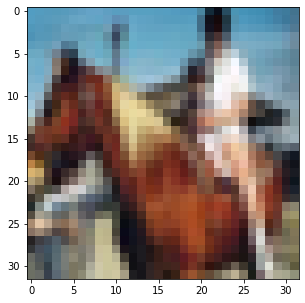

In [8]:
# Plot a sample image (so we can make sure our transformations are correct)
plt.figure(figsize=(5, 5))
plt.imshow(x_train[0].astype(int))
plt.show()

In [9]:
# Some pre-proessing of the image for MobileNet (scaling and shifing to be between [-1, 1])
x_preprocess_train = preprocess_input(x_train.copy())
x_preprocess_test = preprocess_input(x_test.copy())
x_preprocess_train.shape, x_preprocess_test.shape

((1000, 32, 32, 3), (1000, 32, 32, 3))

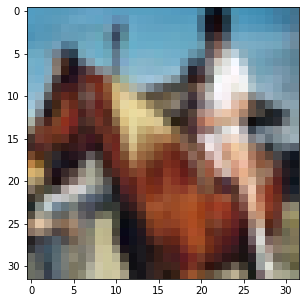

In [10]:
# Plot a sample image (need to shift/scale to dispaly colours properly)
plt.figure(figsize=(5, 5))
plt.imshow((x_preprocess_train[0] + 1.0) * 127.5 / 255)
plt.show()

In [11]:
# Upsample and resize image because it expects an image upto 224x224x3 (this might take a few minutes) 
print('Processing training data')
resized_images = []
for i in range(x_preprocess_train.shape[0]):
    resized_images.append(zoom(x_preprocess_train[i], (5.0, 5.0, 1.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_train = np.stack(resized_images)

print('Processing testing data')
resized_images = []
for i in range(x_preprocess_test.shape[0]):
    resized_images.append(zoom(x_preprocess_test[i], (5.0, 5.0, 1.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_test = np.stack(resized_images)

x_preprocess_train.shape, x_preprocess_test.shape

Processing training data
* Processed 200 images
* Processed 400 images
* Processed 600 images
* Processed 800 images
* Processed 1000 images
Processing testing data
* Processed 200 images
* Processed 400 images
* Processed 600 images
* Processed 800 images
* Processed 1000 images


((1000, 160, 160, 3), (1000, 160, 160, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


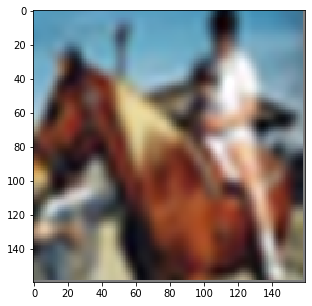

In [12]:
# Plot a sample image (should be resized)
plt.figure(figsize=(5, 5))
plt.imshow((x_preprocess_train[0] + 1.0) * 127.5 / 255)
plt.show()

In [13]:
mobilenet = MobileNet(weights='imagenet', include_top=False)
mobilenet

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step


In [14]:
# Extract features using mobilenet (this may take a few minutes)
x_preprocess_train = mobilenet.predict(x_preprocess_train)
x_preprocess_test = mobilenet.predict(x_preprocess_test)
x_preprocess_train.shape, x_preprocess_test.shape

((1000, 5, 5, 1024), (1000, 5, 5, 1024))

### Model

Let's now build a simple feed-forward network using these features.

MobileNet outputs a (5, 5, 1024) tensor before it's "top layer".  We aggregate this using a "GlobalAveragePooling" layer, which compresses it into a (1, 1, 1024) tensor, which is equivalent to 1024 vector.  It works by taking the average of each 5x5 feature map.

In [15]:
model2 = Sequential()
model2.add(GlobalAveragePooling2D(input_shape=(5, 5, 1024)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 66,250
Trainable params: 66,250
Non-trainable params: 0
_________________________________________________________________


In [16]:
model2.fit(x_preprocess_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           callbacks=[])

In [17]:
train_score = model2.evaluate(x_preprocess_train, y_train, verbose=0)
test_score = model2.evaluate(x_preprocess_test, y_test, verbose=0)

print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Train loss: 0.032209984675049784
Train accuracy: 1.0
Test loss: 0.5518739597797394
Test accuracy: 0.824


## Questions

1. What happens if you don't use the `GlobalAveragePooling2D` layer?  Hypothesize why the performance changed?
2. Why does the image need to be preprocessed via the `preprocess_input()` function?  Hypothesize what happens if we omit this step.
3. Why do we need to resize the image (via `zoom`)?  Note: ImageNet images are 224x224x3, while CIFAR10 images are 32x32x3.  Think about how a "car" or "horse" differ in the two datasets.

# Exercise 3: Using Frozen Layers in a Pre-trained Network

Let's load a pre-trained MobileNet network with frozen layers instead of using pre-processed features.

In [ ]:
x_frozen_preprocess_train = preprocess_input(x_train.copy())
x_frozen_preprocess_test = preprocess_input(x_test.copy())

In [19]:
mobilenet_base = MobileNet(weights='imagenet', include_top=False)
mobilenet_base

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [20]:
model3 = Sequential()

model3.add(UpSampling2D(size=(5,5), input_shape=(32, 32, 3)))
model3.add(mobilenet_base)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(num_classes, activation='softmax'))

# Freeze layers in the base model (i.e. only train the classifier)
for layer in mobilenet_base.layers:
    layer.trainable = False

model3.compile(loss='categorical_crossentropy',
               optimizer=keras.optimizers.Adam(lr=0.001),
               metrics=['accuracy'])
model3.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   multiple                  3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 3,295,114
Trainable params: 66,250
Non-trainable params: 3,228,864
_________________________________________________________________


In [21]:
# This may take a while (unless you're on a GPU) so we'll only do 3 epochs to speed things up.
model3.fit(x_frozen_preprocess_train, y_train,
           batch_size=batch_size,
           epochs=3,
           verbose=0,
           callbacks=[])

In [22]:
train_score = model3.evaluate(x_frozen_preprocess_train, y_train, verbose=0)
test_score = model3.evaluate(x_frozen_preprocess_test, y_test, verbose=0)

print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Train loss: 0.8182290410995483
Train accuracy: 0.753
Test loss: 1.1383354105949401
Test accuracy: 0.592


## Questions

1. Why does the network train so much more slowly?
2. What is the difference (if any) between the model in Exercise 2 and Exercise 3?
3. How would you modify the above code if we wanted to train some of the MobileNet layers?